# Power Spectrum Computation

## Introduction

The main entry point to the power spectrum module is the `calc_power()` function, which takes a set of points, deposits them onto a mesh (optionally with interlacing), computes the mode powers through an FFT, and then computes bandpowers and multipoles. This notebook is a quick demonstration of that function, with a similarly quick sanity check against nbodykit.

## Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abacusnbody.analysis.power_spectrum import calc_power

Load the data:

In [2]:
power_test_data = dict(**np.load('../../../tests/data_power/test_pos.npz'))
Lbox = 1000.0
pos = power_test_data['pos']

Specifications of the power spectrum computation. The only required args are `pos` and `Lbox`.

In [3]:
interlaced = True
compensated = True
paste = 'TSC'
nmesh = 72
nbins_mu = 4
logk = False
k_hMpc_max = np.pi * nmesh / Lbox + 1.0e-6
nbins_k = nmesh // 2
poles = [0, 2, 4]

Compute the power spectrum, including bandpowers and multipoles:

In [4]:
power = calc_power(
    pos,
    Lbox,
    nbins_k,
    nbins_mu,
    k_hMpc_max,
    logk,
    paste,
    nmesh,
    compensated,
    interlaced,
    poles=poles,
)

The result is an Astropy Table. The shape of the `k_avg`, `power`, etc, columns is `(nbins_k,nbins_mu)`. The `poles` column is shape `(nbins_k,len(poles))`.

In [5]:
power

<Table length=36>
       k_min                k_max         ...    mu_max       mu_mid    
      float64              float64        ...  float64[4]   float64[4]  
-------------------- -------------------- ... ----------- --------------
                 0.0 0.006283213084957364 ... 0.25 .. 1.0 0.125 .. 0.875
0.006283213084957364 0.012566426169914728 ... 0.25 .. 1.0 0.125 .. 0.875
0.012566426169914728 0.018849639254872094 ... 0.25 .. 1.0 0.125 .. 0.875
0.018849639254872094 0.025132852339829457 ... 0.25 .. 1.0 0.125 .. 0.875
0.025132852339829457 0.031416065424786824 ... 0.25 .. 1.0 0.125 .. 0.875
0.031416065424786824  0.03769927850974419 ... 0.25 .. 1.0 0.125 .. 0.875
 0.03769927850974419  0.04398249159470155 ... 0.25 .. 1.0 0.125 .. 0.875
 0.04398249159470155 0.050265704679658914 ... 0.25 .. 1.0 0.125 .. 0.875
0.050265704679658914  0.05654891776461628 ... 0.25 .. 1.0 0.125 .. 0.875
 0.05654891776461628  0.06283213084957365 ... 0.25 .. 1.0 0.125 .. 0.875
                 ...                  ... ...         ...            ...
 0.16336354020889146  0.16964675329384885 ... 0.25 .. 1.0 0.125 .. 0.875
 0.16964675329384885   0.1759299663788062 ... 0.25 .. 1.0 0.125 .. 0.875
  0.1759299663788062  0.18221317946376356 ... 0.25 .. 1.0 0.125 .. 0.875
 0.18221317946376356  0.18849639254872091 ... 0.25 .. 1.0 0.125 .. 0.875
 0.18849639254872091   0.1947796056336783 ... 0.25 .. 1.0 0.125 .. 0.875
  0.1947796056336783  0.20106281871863566 ... 0.25 .. 1.0 0.125 .. 0.875
 0.20106281871863566    0.207346031803593 ... 0.25 .. 1.0 0.125 .. 0.875
   0.207346031803593   0.2136292448885504 ... 0.25 .. 1.0 0.125 .. 0.875
  0.2136292448885504  0.21991245797350775 ... 0.25 .. 1.0 0.125 .. 0.875
 0.21991245797350775   0.2261956710584651 ... 0.25 .. 1.0 0.125 .. 0.875

The `meta` field saves some information about how the power spectrum was calculated:

In [6]:
power.meta

{'Lbox': 1000.0,
 'logk': False,
 'paste': 'TSC',
 'nmesh': 72,
 'compensated': True,
 'interlaced': True,
 'poles': [0, 2, 4],
 'nthread': 24,
 'N_pos': 421791,
 'is_weighted': False,
 'field_dtype': numpy.float32,
 'squeeze_mu_axis': True}

## Compare with nbodykit

Load presaved nbodykit computation:

In [7]:
comp_str = '_compensated' if compensated else ''
int_str = '_interlaced' if interlaced else ''
fn = f'../../../tests/data_power/nbody_{paste}{comp_str}{int_str}.npz'
data = np.load(fn)
k_nbody = data['k']
Pkmu_nbody = data['power'].real
Pell_nbody = data['power_ell'].real

Plot and compare:

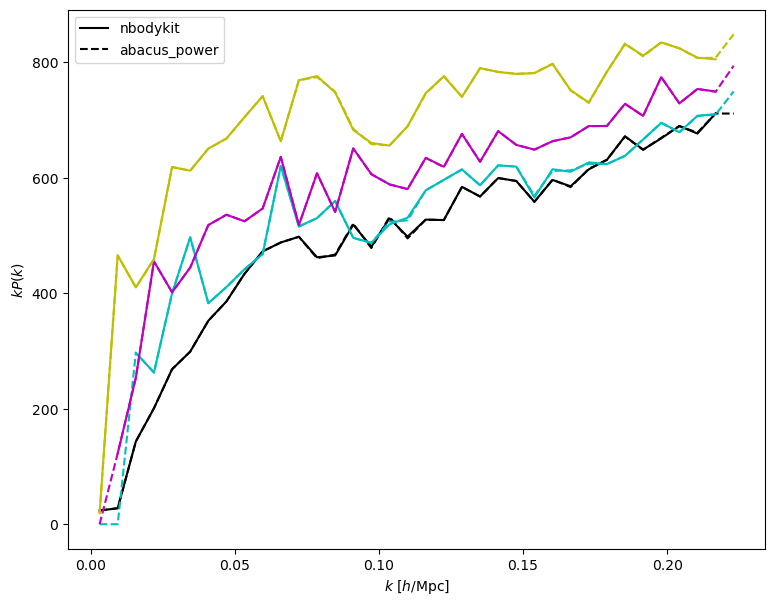

In [8]:
colors = ['k', 'c', 'm', 'y']
plt.figure(figsize=(9, 7))
for i in range(nbins_mu):
    if i == 0:
        label1 = 'nbodykit'
        label2 = 'abacus_power'
    else:
        label1 = label2 = None
    plt.plot(k_nbody, Pkmu_nbody[:, i] * k_nbody, c=colors[i], label=label1)
    plt.plot(
        power['k_mid'],
        power['power'][:, i] * power['k_mid'],
        c=colors[i],
        ls='--',
        label=label2,
    )
plt.ylabel(r'$k P(k)$')
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.legend();

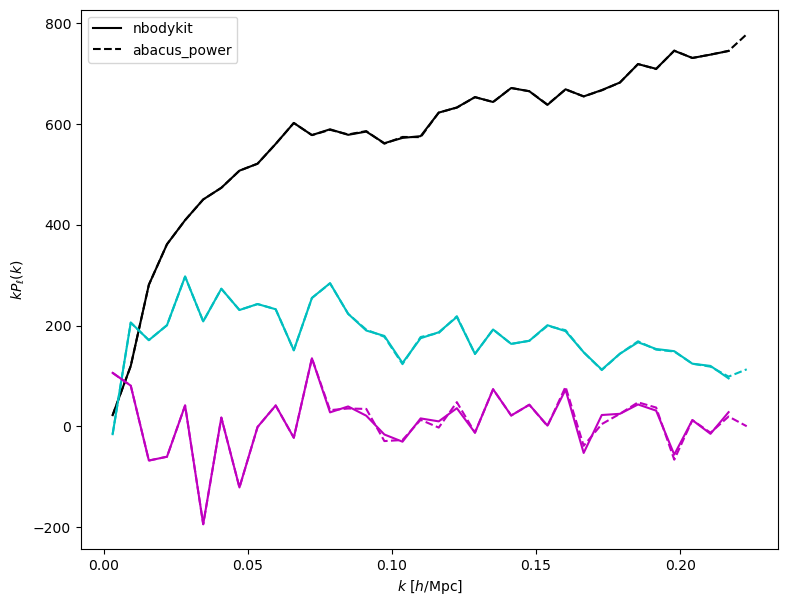

In [9]:
# plot and compare
plt.figure(figsize=(9, 7))
for i in range(len(poles)):
    if i == 0:
        label1 = 'nbodykit'
        label2 = 'abacus_power'
    else:
        label1 = label2 = None
    plt.plot(k_nbody, Pell_nbody[i, :] * k_nbody, c=colors[i], label=label1)
    plt.plot(
        power['k_mid'],
        power['poles'][:, i] * power['k_mid'],
        c=colors[i],
        ls='--',
        label=label2,
    )
plt.ylabel(r'$k P_\ell(k)$')
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.legend();